In [1]:
# imports
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from sklearn import preprocessing
# have to do this for art to work
tf.compat.v1.disable_eager_execution()

### Introduction  
After failing to create a lstm model that correctly classifies real minute tsla data in this notebook we will attempt to use a simple sine wave and see if we can get a higher accuracy.

In [2]:
x = np.arange(0,10000,0.1)
sx = np.sin(x)

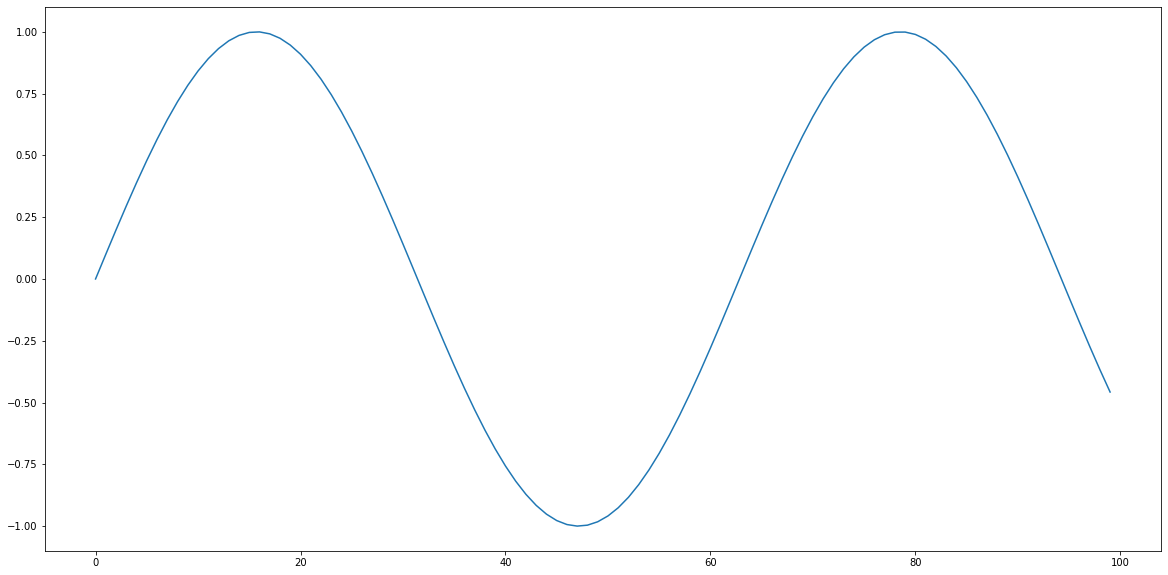

In [3]:
plt.plot(sx[:100])

In [4]:
# to turn the regression problem into a classification problem we have to make the y labels of a certain class
# lets split the data 'forecast' into ranges
print(sx.min(),sx.max())
# our data is from -1 to 1 and should have a good distrobution. So if we wanted to split into 3 classes
# we could get values from -1 to -.5, -.5 to 0, and 0 to .5, .5 to 1
for i in [-1,-.5,.0,.5]:
    print(i,np.count_nonzero(sx>i)-np.count_nonzero(sx<(i+.5)))

-0.9999999989777327 0.9999999998864147
-1 66677
-0.5 16693
0.0 -16643
0.5 -66658


In [5]:
# pushes all values into 4 classes, from 0 to 1 because that's what we scale it
# UPDATED to take into account the previous value so it will classify by direction. 
def map_to_class(prev, value):
    if value >= .75:
        if prev < value: # rising
            return 3
        else: # falling
            return 7
    if value >= .5 and value < .75:
        if prev < value: # rising
            return 2
        else: # falling
            return 6
        return 2
    if value >= .25 and value < .5:
        if prev < value: # rising
            return 1
        else: # falling
            return 5
        return 1
    if value < .25:
        if prev < value: # rising
            return 0
        else: # falling
            return 4
    print('error',value)
    return 0

In [13]:
dataset = pd.DataFrame(sx, columns=['value'])
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(map_to_class(dataset[i+look_back-1, 0],dataset[i + look_back, 0]))
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [14]:
train[10,0]

0.9207355

In [15]:
# we have a nice distrobution
np.unique(Y_train,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([12695,  6662,  6671, 13964, 13968,  6665,  6663, 12681],
       dtype=int64))

In [16]:
X_train.shape

(79969, 1, 30)

In [17]:
X_test.shape

(19969, 1, 30)

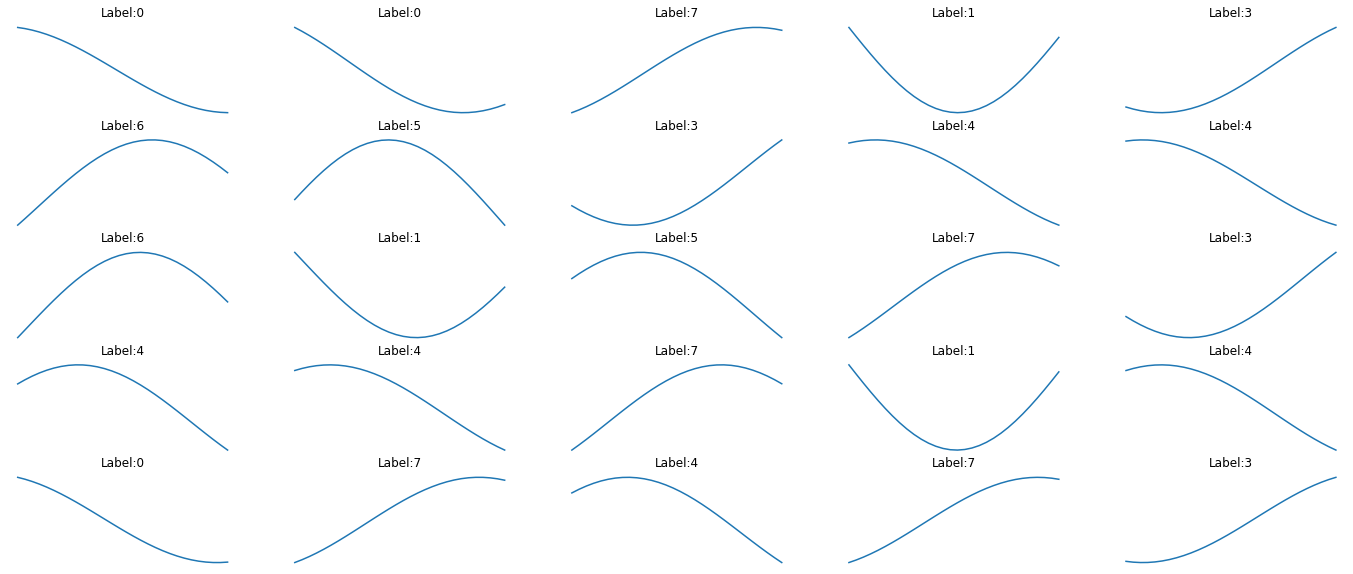

In [20]:
plt.figure(figsize=(24, 10))
for n in range(25):
    i = np.random.randint(0, len(X_train), 1)[0]
    ax = plt.subplot(5, 5, n+1)
    plt.plot(X_train[i, 0])
    plt.title('Label:' + str(Y_train[i]))
    plt.axis('off')

### Classifications  
In the previous work proj_lstm_forecaster_simpleine_2 the classes were insufficent to show direction and therefore made the whole study less worthwhile.In this version there are 8 labels and the label will always correspond to the same direction. So in the example above label 4 for example is a downward slope, label 3 is upward and so on. Yes the future values may be anything because at some point it will be 'turning over' and thus the previous data will misreflect the future data, but using previous data to predict future class is the best a lstm can do for our purposes.  
  
NOTE: 0-3 are rising, 4-8 are falling

In [21]:
from tensorflow.keras.optimizers import *
model = Sequential()
# lstm layer
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
#model.add(Dropout(0.2))
model.add(Dense(X_train.shape[2]))  
model.add(Dropout(0.5))  
# some dense layers
model.add(Dense(512,activation='relu'))  
# output layer
model.add(Dense(len(np.unique(Y_train)),activation='softmax')) # number of classes in Y

model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate = 1e-4))

history = model.fit(X_train, Y_train, epochs=5, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)], verbose=1, shuffle=False)

model.summary()

Train on 79969 samples, validate on 19969 samples
Epoch 1/5
79730/79969 [============================>.] - ETA: 0s - loss: 0.6075 - accuracy: 0.7781

C:\ML\nvidiatf\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


79969/79969 [==============================] - 16s 205us/sample - loss: 0.6065 - accuracy: 0.7784 - val_loss: 0.1208 - val_accuracy: 0.9818
Epoch 2/5
79969/79969 [==============================] - 11s 136us/sample - loss: 0.1730 - accuracy: 0.9307 - val_loss: 0.0806 - val_accuracy: 0.9857
Epoch 3/5
79969/79969 [==============================] - 11s 136us/sample - loss: 0.1200 - accuracy: 0.9535 - val_loss: 0.0605 - val_accuracy: 0.9909
Epoch 4/5
79969/79969 [==============================] - 11s 137us/sample - loss: 0.0938 - accuracy: 0.9650 - val_loss: 0.0492 - val_accuracy: 0.9902
Epoch 5/5
79969/79969 [==============================] - 11s 140us/sample - loss: 0.0772 - accuracy: 0.9717 - val_loss: 0.0430 - val_accuracy: 0.9895
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               293888    
__________________________________________

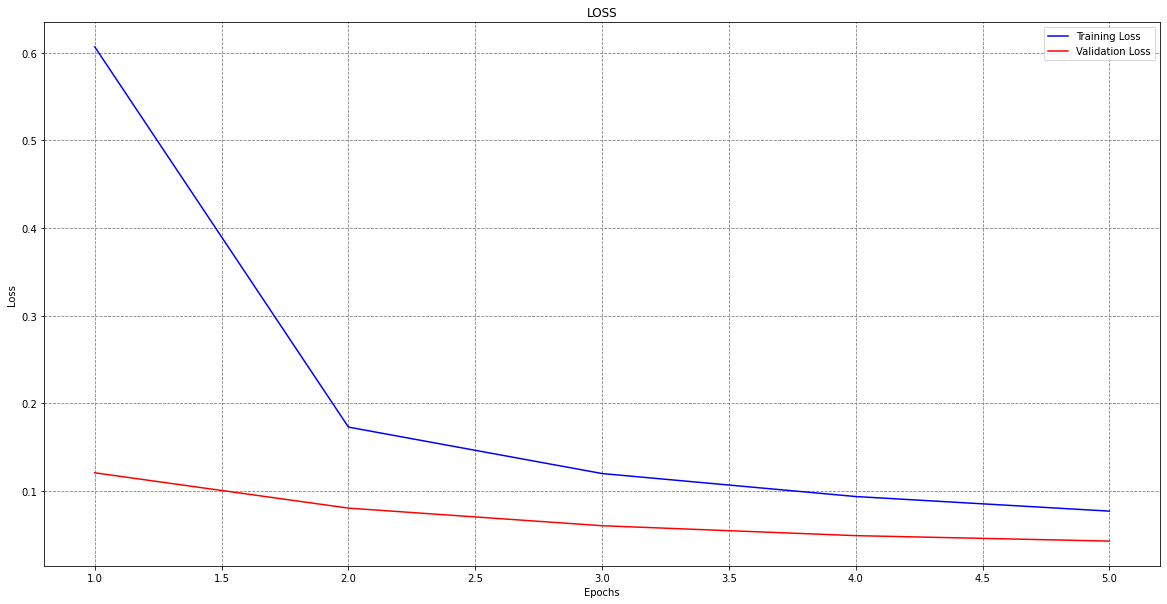

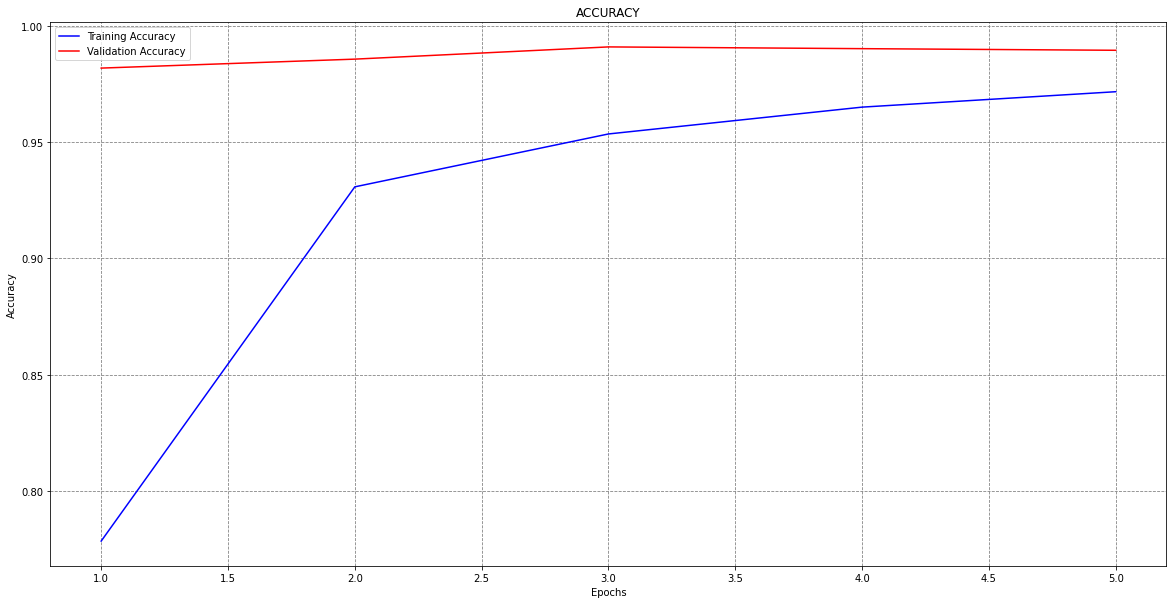

In [22]:
# PLot the loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy']

epochsn = np.arange(1, len(train_loss)+1,1)
plt.plot(epochsn,train_loss, 'b', label='Training Loss')
plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure()
plt.plot(epochsn, acc, 'b', label='Training Accuracy')
plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
plt.grid(color='gray', linestyle='--')
plt.legend()            
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show() 

In [17]:
!pip install adversarial-robustness-toolbox

You should consider upgrading via the 'C:\ML\nvidiatf\Scripts\python.exe -m pip install --upgrade pip' command.


In [23]:
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import KerasClassifier

In [24]:
classifier = KerasClassifier(model=model, use_logits=False)

In [25]:
# FGSM attack
epsilon = [0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8]

fgsm_attack_acc = []
fgsm_attacks = []
for eps in epsilon:
    attack_fgsm = FastGradientMethod(estimator=classifier, eps=eps)
    fgsm_attack_adv_data = attack_fgsm.generate(X_test)
    fgsm_attacks.append(fgsm_attack_adv_data)
    loss_test, accuracy_test = model.evaluate(fgsm_attack_adv_data, Y_test)
    fgsm_attack_acc.append(accuracy_test)
    perturbation = np.mean(np.abs((fgsm_attack_adv_data - X_test)))
    print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
    print('Average perturbation: {:4.2f}'.format(perturbation))

C:\ML\nvidiatf\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Accuracy on adversarial test data: 93.22%
Average perturbation: 0.01
Accuracy on adversarial test data: 81.56%
Average perturbation: 0.02
Accuracy on adversarial test data: 61.84%
Average perturbation: 0.05
Accuracy on adversarial test data: 28.68%
Average perturbation: 0.10
Accuracy on adversarial test data: 10.11%
Average perturbation: 0.20
Accuracy on adversarial test data: 2.28%
Average perturbation: 0.30
Accuracy on adversarial test data: 0.90%
Average perturbation: 0.50
Accuracy on adversarial test data: 0.74%
Average perturbation: 0.80


### Analyze the attack  
The purpose of this whole exercise was to show a structure which could be used to predict when trading algorithms would fail causing 'flash crash' like effects in the stock market. So now we go over the attacks and try and find patterns

In [26]:
atk = fgsm_attacks[3] #purturbation epsilon .1 accuarcy 47
atk_y = model.predict(atk)
atk_y = np.argmax(atk_y, axis=1)
atk.shape

(19969, 1, 30)

In [27]:
acc = model.evaluate(atk,Y_test)
print(f'Accuracy at e=.1 is %.2f'%acc[1])

Accuracy at e=.1 is 0.29


In [28]:
atk_y[0:10]

array([0, 0, 0, 4, 4, 4, 4, 0, 0, 0], dtype=int64)

In [29]:
Y_test[0:10]

array([4, 4, 4, 0, 0, 0, 0, 0, 0, 0])

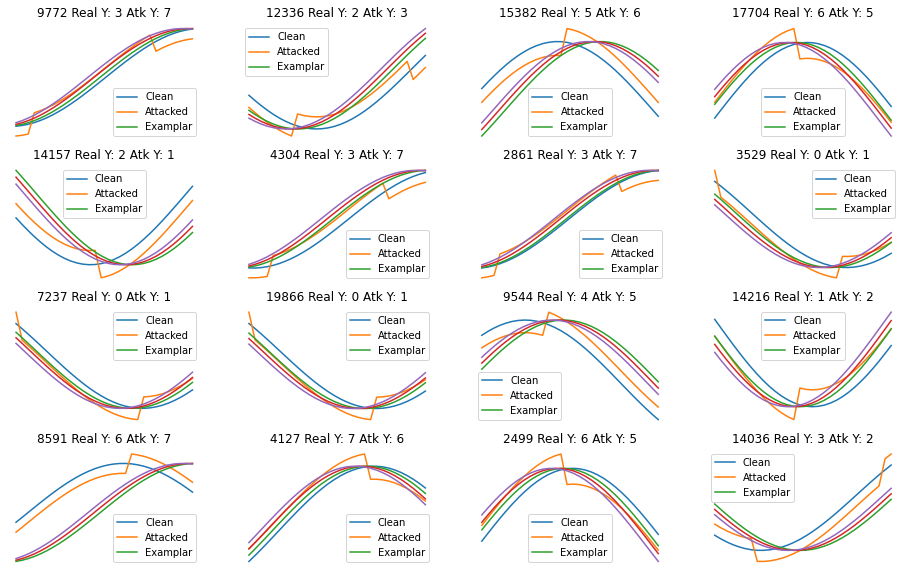

In [30]:
import random
plt.figure(figsize=(16, 10))
for n in range(16):
    # let's only focus on missed labeled examples
    misses = np.where(Y_test != atk_y)[0]
    #i = np.random.randint(0, len(misses), 1)[0]
    i = random.choice(misses)
    ax = plt.subplot(4, 4, n+1)
    plt.plot(X_test[i, 0])
    plt.plot(atk[i, 0])
    plt.title(f'Real Y: %d Atk Y: %d'%(Y_test[i],atk_y[i]))
    plt.legend(['Clean','Attacked'])
    if Y_test[i] != atk_y[i]:
        plt.title(f'%d Real Y: %d Atk Y: %d'%(i, Y_test[i],atk_y[i]))
        examplar_ind = np.where(Y_test==atk_y[i])[0] # get an example to see what it was mislabeled as
        plt.plot(X_test[examplar_ind[0], 0])
        plt.plot(X_test[examplar_ind[1], 0])
        plt.plot(X_test[examplar_ind[2], 0])
        plt.legend(['Clean','Attacked','Examplar'])
        
    plt.axis('off')

In [31]:
# show that it's not actually a miss classifiction
from sklearn.metrics import mean_squared_error
# mse between the attack and the supposed actual target class
mse_base = mean_squared_error(X_test[i,0], atk[i,0])
# mse between the attack and the 'miss classification'
mse_target = mean_squared_error(X_test[examplar_ind[0],0], atk[i,0])

print(f'MSE base: %.4f, MSE target: %.4f'%(mse_base,mse_target))

MSE base: 0.0100, MSE target: 0.0316


Found 12758/19969 indexes really missclassified


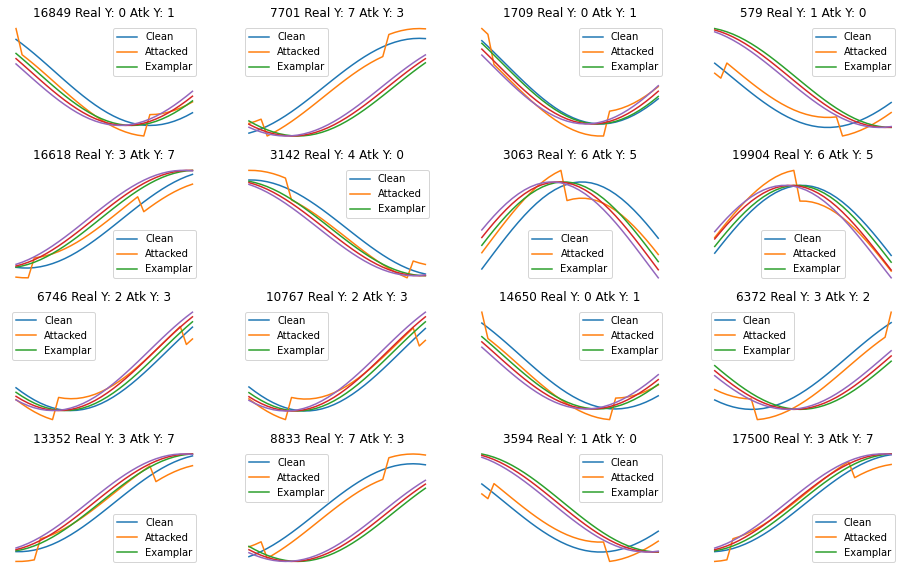

In [33]:
plt.figure(figsize=(16, 10))
misses = np.where(Y_test != atk_y)[0]
found_indexes = []
mse_values = []
for i in misses:
    mse_base = mean_squared_error(X_test[i,0], atk[i,0])
    mse_target = mean_squared_error(X_test[examplar_ind[0],0], atk[i,0])
    if mse_base < mse_target:
        mse_values.append(mse_target-mse_base)
        found_indexes.append(i)
print(f'Found %d/%d indexes really missclassified'%(len(found_indexes),X_test.shape[0]))
for n in range(16):
    i = random.choice(found_indexes)
    ax = plt.subplot(4, 4, n+1)
    plt.plot(X_test[i, 0])
    plt.plot(atk[i, 0])
    plt.title(f'Real Y: %d Atk Y: %d'%(Y_test[i],atk_y[i]))
    plt.legend(['Clean','Attacked'])
    if Y_test[i] != atk_y[i]:
        plt.title(f'%d Real Y: %d Atk Y: %d'%(i, Y_test[i],atk_y[i]))
        examplar_ind = np.where(Y_test==atk_y[i])[0] # get an example to see what it was mislabeled as
        plt.plot(X_test[examplar_ind[0], 0])
        plt.plot(X_test[examplar_ind[1], 0])
        plt.plot(X_test[examplar_ind[2], 0])
        plt.legend(['Clean','Attacked','Examplar'])
        
    plt.axis('off')

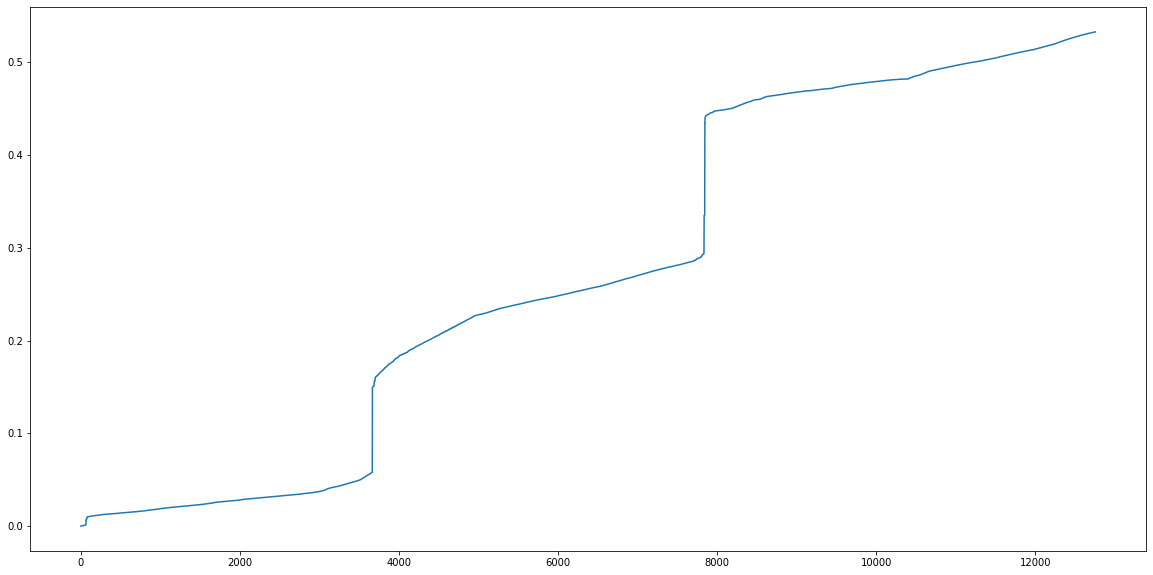

In [34]:
# now lets look at the distrobution because a lot of them will be close misclassifications like 15796 and we dont so much care about those
plt.plot(sorted(mse_values))

In [35]:
sorted(mse_values)[-16:]

[0.5325447,
 0.53259,
 0.5325934,
 0.53259706,
 0.53264207,
 0.5326455,
 0.5326491,
 0.5326939,
 0.5326974,
 0.5327009,
 0.53274554,
 0.53274906,
 0.5327525,
 0.53279704,
 0.5328006,
 0.53280395]

Found 14242/19969 indexes really missclassified


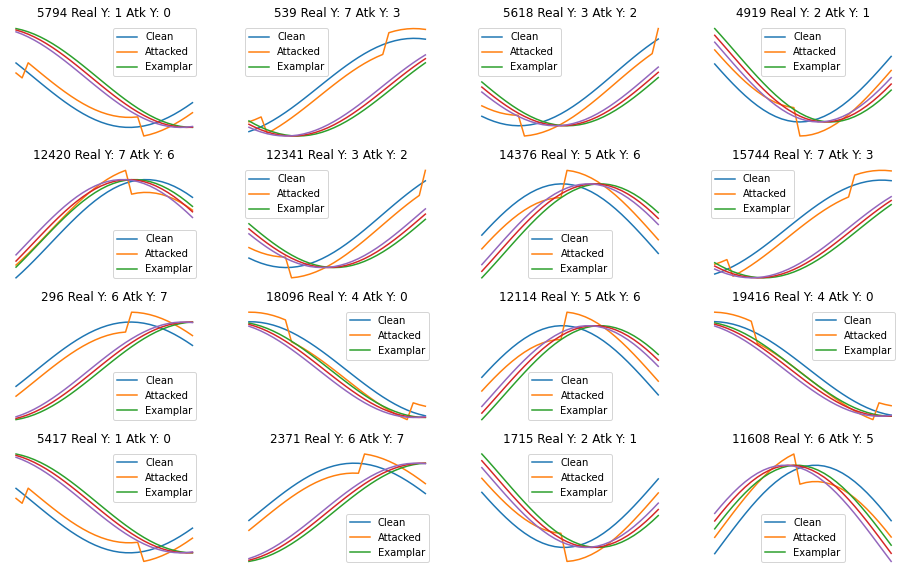

In [36]:
# lets look at the worst of the worst misclassifications
plt.figure(figsize=(16, 10))
misses = np.where(Y_test != atk_y)[0]
found_indexes = []
mse_values = []
for i in misses:
    mse_base = mean_squared_error(X_test[i,0], atk[i,0])
    mse_target = mean_squared_error(X_test[examplar_ind[0],0], atk[i,0])
    if mse_base < mse_target+.547:
        mse_values.append(mse_target-mse_base)
        found_indexes.append(i)
print(f'Found %d/%d indexes really missclassified'%(len(found_indexes),X_test.shape[0]))
for n in range(16):
    i = random.choice(found_indexes)
    ax = plt.subplot(4, 4, n+1)
    plt.plot(X_test[i, 0])
    plt.plot(atk[i, 0])
    plt.title(f'Real Y: %d Atk Y: %d'%(Y_test[i],atk_y[i]))
    plt.legend(['Clean','Attacked'])
    if Y_test[i] != atk_y[i]:
        plt.title(f'%d Real Y: %d Atk Y: %d'%(i, Y_test[i],atk_y[i]))
        examplar_ind = np.where(Y_test==atk_y[i])[0] # get an example to see what it was mislabeled as
        plt.plot(X_test[examplar_ind[0], 0])
        plt.plot(X_test[examplar_ind[1], 0])
        plt.plot(X_test[examplar_ind[2], 0])
        plt.legend(['Clean','Attacked','Examplar'])
        
    plt.axis('off')

(-1.4500000000000002, 30.45, -0.05496053546667099, 1.1544630095362662)

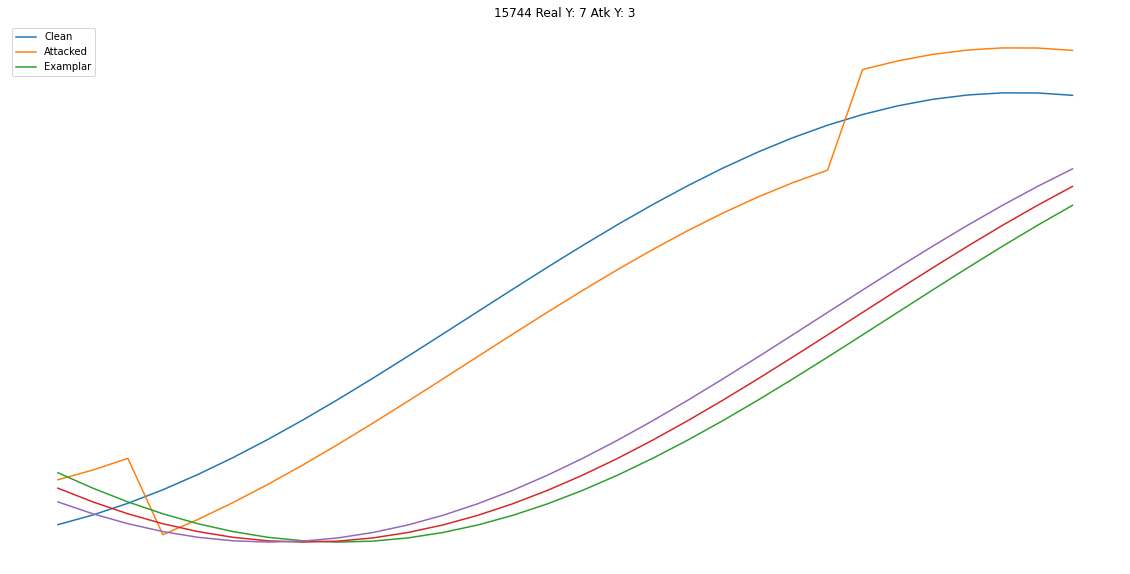

In [50]:

i = 15744
plt.plot(X_test[i, 0])
plt.plot(atk[i, 0])
plt.title(f'Real Y: %d Atk Y: %d'%(Y_test[i],atk_y[i]))
plt.legend(['Clean','Attacked'])
if Y_test[i] != atk_y[i]:
    plt.title(f'%d Real Y: %d Atk Y: %d'%(i, Y_test[i],atk_y[i]))
    examplar_ind = np.where(Y_test==atk_y[i])[0] # get an example to see what it was mislabeled as
    plt.plot(X_test[examplar_ind[0], 0])
    plt.plot(X_test[examplar_ind[1], 0])
    plt.plot(X_test[examplar_ind[2], 0])
    plt.legend(['Clean','Attacked','Examplar'])

plt.axis('off')

Found 1761/19969 indexes really missclassified


<Figure size 1152x720 with 0 Axes>

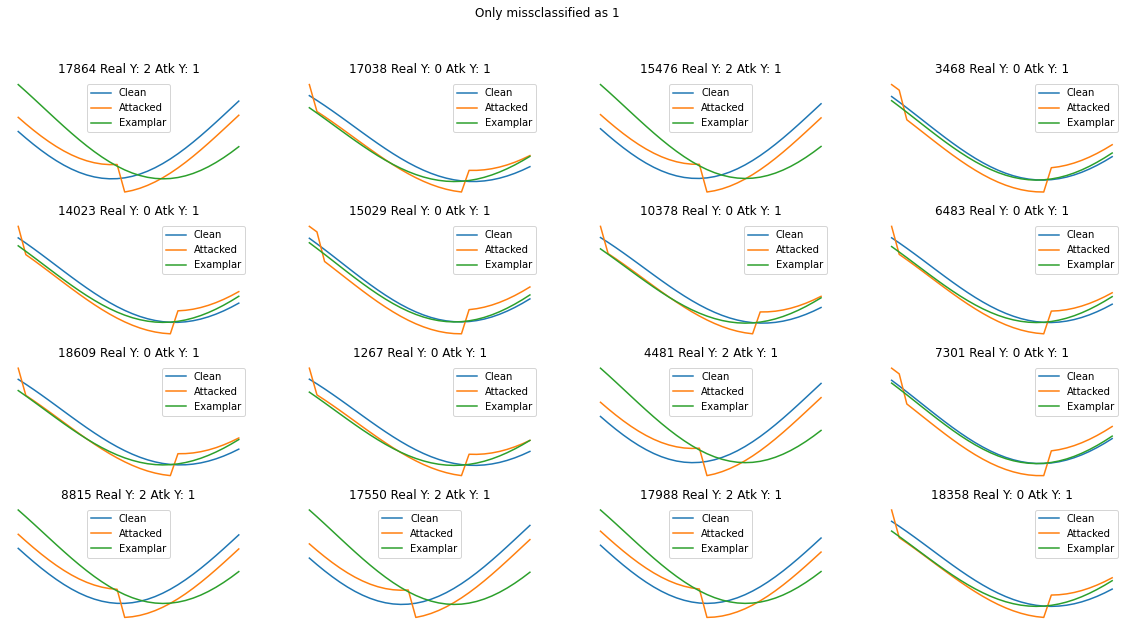

In [37]:
# I notice a pattern here, lets ONLY look at mislables of 1
plt.figure(figsize=(16, 10))
misses = np.where((Y_test != atk_y) & (atk_y == 1))[0]
found_indexes = []
mse_values = []
for i in misses:
    mse_base = mean_squared_error(X_test[i,0], atk[i,0])
    mse_target = mean_squared_error(X_test[examplar_ind[0],0], atk[i,0])
    if mse_base < mse_target+.547:
        mse_values.append(mse_target-mse_base)
        found_indexes.append(i)
print(f'Found %d/%d indexes really missclassified'%(len(found_indexes),X_test.shape[0]))
fig, ax = plt.subplots(4, 4)
fig.suptitle('Only missclassified as 1')
for n in range(16):
    i = random.choice(found_indexes)
    ax = plt.subplot(4, 4, n+1)
    plt.plot(X_test[i, 0])
    plt.plot(atk[i, 0])
    plt.title(f'Real Y: %d Atk Y: %d'%(Y_test[i],atk_y[i]))
    plt.legend(['Clean','Attacked'])
    if Y_test[i] != atk_y[i]:
        plt.title(f'%d Real Y: %d Atk Y: %d'%(i, Y_test[i],atk_y[i]))
        examplar_ind = np.where(Y_test==atk_y[i])[0] # get an example to see what it was mislabeled as
        plt.plot(X_test[examplar_ind[0], 0])
        plt.legend(['Clean','Attacked','Examplar'])
        
    plt.axis('off')


Found 1756/19969 indexes really missclassified


<Figure size 1152x720 with 0 Axes>

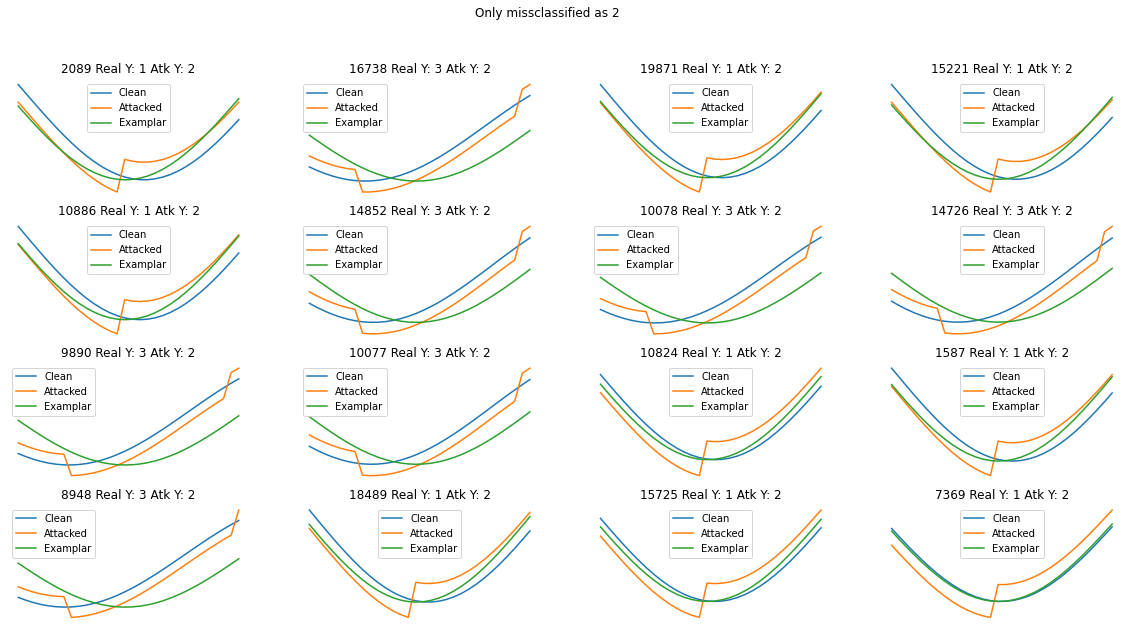

In [38]:
# I notice a pattern here, lets ONLY look at mislables of 2
plt.figure(figsize=(16, 10))
misses = np.where((Y_test != atk_y) & (atk_y ==2))[0]
found_indexes = []
mse_values = []
for i in misses:
    mse_base = mean_squared_error(X_test[i,0], atk[i,0])
    mse_target = mean_squared_error(X_test[examplar_ind[0],0], atk[i,0])
    if mse_base < mse_target+.547:
        mse_values.append(mse_target-mse_base)
        found_indexes.append(i)
print(f'Found %d/%d indexes really missclassified'%(len(found_indexes),X_test.shape[0]))
fig, ax = plt.subplots(4, 4)
fig.suptitle('Only missclassified as 2')
for n in range(16):
    i = random.choice(found_indexes)
    ax = plt.subplot(4, 4, n+1)
    plt.plot(X_test[i, 0])
    plt.plot(atk[i, 0])
    plt.title(f'Real Y: %d Atk Y: %d'%(Y_test[i],atk_y[i]))
    plt.legend(['Clean','Attacked'])
    if Y_test[i] != atk_y[i]:
        plt.title(f'%d Real Y: %d Atk Y: %d'%(i, Y_test[i],atk_y[i]))
        examplar_ind = np.where(Y_test==atk_y[i])[0] # get an example to see what it was mislabeled as
        plt.plot(X_test[examplar_ind[0], 0])
        plt.legend(['Clean','Attacked','Examplar'])
        
    plt.axis('off')


Found 2307/19969 indexes really missclassified


<Figure size 1152x720 with 0 Axes>

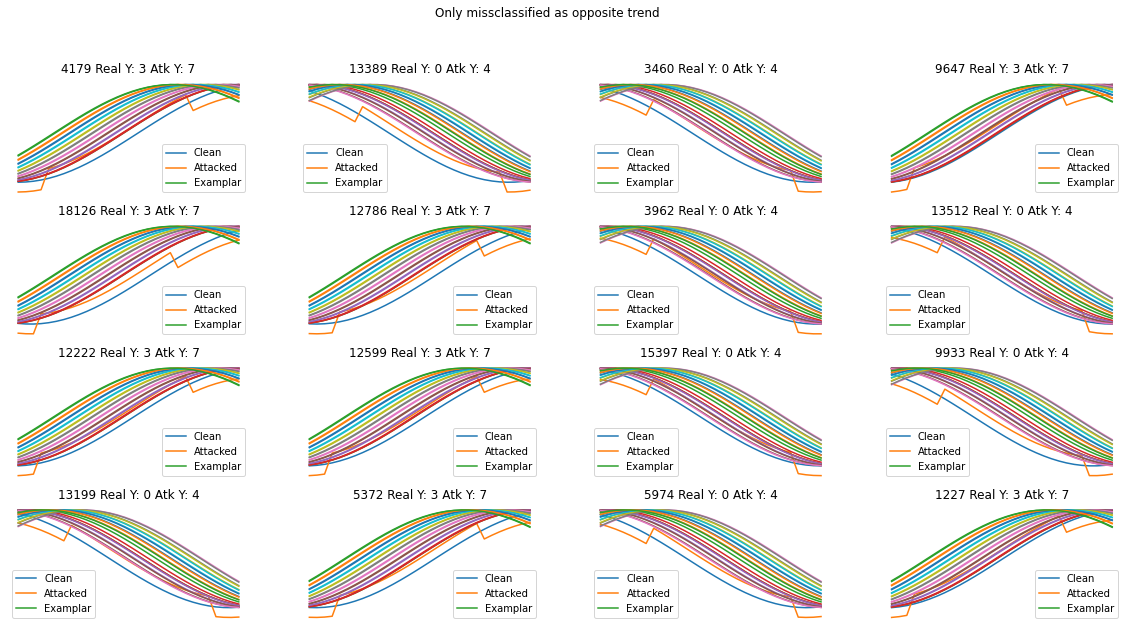

In [44]:
# what we need now is uptrends that were missclassified as downtrends and visa versa
# I notice a pattern here, lets ONLY look at mislables of 2
plt.figure(figsize=(16, 10))
misses = np.where((Y_test < 4) & (atk_y >= 4))[0]
found_indexes = []
mse_values = []
for i in misses:
    mse_base = mean_squared_error(X_test[i,0], atk[i,0])
    mse_target = mean_squared_error(X_test[examplar_ind[0],0], atk[i,0])
    if mse_base < mse_target+.547:
        mse_values.append(mse_target-mse_base)
        found_indexes.append(i)
print(f'Found %d/%d indexes really missclassified'%(len(found_indexes),X_test.shape[0]))
fig, ax = plt.subplots(4, 4)
fig.suptitle('Only missclassified as opposite trend')
for n in range(16):
    i = random.choice(found_indexes)
    ax = plt.subplot(4, 4, n+1)
    plt.plot(X_test[i, 0])
    plt.plot(atk[i, 0])
    plt.title(f'Real Y: %d Atk Y: %d'%(Y_test[i],atk_y[i]))
    plt.legend(['Clean','Attacked'])
    if Y_test[i] != atk_y[i]:
        plt.title(f'%d Real Y: %d Atk Y: %d'%(i, Y_test[i],atk_y[i]))
        examplar_ind = np.where(Y_test==atk_y[i])[0] # get an example to see what it was mislabeled as
        plt.plot(X_test[examplar_ind[0], 0])
        for j in range(20):
            plt.plot(X_test[examplar_ind[j], 0])
        plt.legend(['Clean','Attacked','Examplar'])
        
    plt.axis('off')

### Conclusion 3  
When I added direction into the class there were no more opposite eye like figures due to classification of direct opposite. This makes for much less interesting miss classifications due to attacks. The only 'upward' trends that were able to be missclassified as 'downward' and so on were trends at the point of inflection, exactly where the sine wave turns over as can be seen in the figure above. This means that it only miss classifies trends where the trend is neither up or down. Essentially labels (3,7) and (0,4) are the same. As you can see below in the unique counts classes 0,3 and 4,7 were the only ones missclassified as they are duplicates. So if the data is classified correctly with direction and trend an attack cannot really show a scenario where it is wrong enough to mislabel the trend.  

In [48]:
np.unique(Y_test[misses])


array([0, 3])

In [49]:
np.unique(atk_y[misses])

array([4, 7], dtype=int64)